In [ ]:
# Neural Networks

# Class Notes:

# predict total number of bike rentals that occured?
# y is casual and registered combined.
# how do we want the data fed into the network?
# how will we use the data from 2020, the lockdown?
# combine values from hum and temp_c, feature enginere road conditions.
# trend from weather and covid.
# What were the exact dates the DC lockdown?
# frequency, average trend of busier times
# look at the tourist Season
# use both temp_c and temp_f

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

bikes = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes.csv')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Feature Engineering

In [3]:
def get_day_of_year(row):
  date_list = row["dteday"].split("/")

  month = int(date_list[0])
  day = int(date_list[1])
  year = int(date_list[2]) # check for leap years

  if month == 1:
    days = day
  elif month == 2:
    days = day + 31
  elif month == 3:
    days = day + 31 + 28
  elif month == 4:
    days = day + 31 + 28 + 31
  elif month == 5:
    days = day + 31 + 28 + 31 + 30
  elif month == 6:
    days = day + 31 + 28 + 31 + 30 + 31
  elif month == 7:
    days = day + 31 + 28 + 31 + 30 + 31 + 30
  elif month == 8:
    days = day + 31 + 28 + 31 + 30 + 31 + 30 + 31
  elif month == 9:
    days = day + 31 + 28 + 31 + 30 + 31 + 30 + 31 + 31
  elif month == 10:
    days = day + 31 + 28 + 31 + 30 + 31 + 30 + 31 + 31 + 30
  elif month == 11:
    days = day + 31 + 28 + 31 + 30 + 31 + 30 + 31 + 31 + 30 + 31
  elif month == 12:
    days = day + 31 + 28 + 31 + 30 + 31 + 30 + 31 + 31 + 30 + 31 + 30

  if year % 4 == 0:
    days += 1

  return int(days)

def get_day_of_four_years(row):
  # there are 1461 days in four years but I want everything to be centered around election year
  year = int(row["dteday"].split("/")[2])
  day = int(row["dteday"].split("/")[1])

  days = ((year % 4) * 365) + day
  if year % 4 != 0:
    days += 1

  return int(days)

In [4]:
def preprocess_bike_data(df):
    df["day_of_year"] = df.apply(get_day_of_year, axis=1)
    df["day_of_four_years"] = df.apply(get_day_of_four_years, axis=1)

    # Convert 'dteday' to datetime
    df['dteday'] = pd.to_datetime(df['dteday'], format='%m/%d/%Y')

    # Ensure 'hr' is an integer
    df['hr'] = df['hr'].astype(int)

    # Combine 'dteday' and 'hr' into a single 'datetime' column
    df['datetime'] = df.apply(lambda row: pd.Timestamp(row['dteday']) + pd.Timedelta(hours=row['hr']), axis=1)

    # Create year, month, and day columns
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['day_of_week'] = df['datetime'].dt.dayofweek

    return df

In [5]:
# Preprocess the main data
bikes = preprocess_bike_data(bikes)

bikes.head()

,dteday,hr,casual,registered,temp_c,feels_like_c,hum,windspeed,weathersit,season,holiday,workingday,day_of_year,day_of_four_years,datetime,year,month,day,day_of_week
0,2011-01-01,0,3,13,3.0,3.0,0.7957,0.8,1,1,0,0,1,1097,2011-01-01 00:00:00,2011,1,1,5
1,2011-01-01,1,8,30,1.7,1.7,0.8272,0.8,1,1,0,0,1,1097,2011-01-01 01:00:00,2011,1,1,5
2,2011-01-01,2,5,26,1.9,1.9,0.8157,1.1,1,1,0,0,1,1097,2011-01-01 02:00:00,2011,1,1,5
3,2011-01-01,3,3,9,2.5,2.5,0.7831,0.8,1,1,0,0,1,1097,2011-01-01 03:00:00,2011,1,1,5
4,2011-01-01,4,0,1,2.0,2.0,0.8075,1.1,1,1,0,0,1,1097,2011-01-01 04:00:00,2011,1,1,5


#

In [6]:
'''
This is a chronological train/ test/ val split.
'''

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Ensure the data is sorted by 'datetime' to maintain chronological order
bikes = bikes.sort_values(by='datetime')

# Create the target variable
bikes['combined_y'] = bikes['casual'] + bikes['registered']
y = bikes['combined_y']

# Define indices for chronological splitting
train_size = int(0.7 * len(bikes))
val_size = int(0.15 * len(bikes))
test_size = len(bikes) - train_size - val_size

# Split the data chronologically
train_data = bikes[:train_size]
val_data = bikes[train_size:train_size + val_size]
test_data = bikes[train_size + val_size:]

# Separate features and target for training and testing sets
y_train = train_data['combined_y']
y_val = val_data['combined_y']
y_test = test_data['combined_y']

X_train = train_data.drop(['combined_y', 'dteday', 'datetime', 'casual', 'registered'], axis=1)
X_val = val_data.drop(['combined_y', 'dteday', 'datetime', 'casual', 'registered'], axis=1)
X_test = test_data.drop(['combined_y', 'dteday', 'datetime', 'casual', 'registered'], axis=1)

# Scale the data
minmax_scaler = preprocessing.MinMaxScaler()
X_train = minmax_scaler.fit_transform(X_train)
X_val = minmax_scaler.transform(X_val)
X_test = minmax_scaler.transform(X_test)

# Display the shapes of the datasets to verify
print(f'Training data shape: {X_train.shape}, Training target shape: {y_train.shape}')
print(f'Validation data shape: {X_val.shape}, Validation target shape: {y_val.shape}')
print(f'Testing data shape: {X_test.shape}, Testing target shape: {y_test.shape}')

Training data shape: (78732, 15), Training target shape: (78732,)
Validation data shape: (16871, 15), Validation target shape: (16871,)
Testing data shape: (16872, 15), Testing target shape: (16872,)


In [7]:
from keras.models import Sequential
from keras.layers import Dense

# Initialize the Neural Network
model = Sequential() # Sequential just means the network doesn't have loops--the outputs of one layer of neurons go to the next layer of neurons

# Add the first layer
model.add(Dense(16, input_dim=15, activation='relu')) # This layer has 16 neurons. They are each connected (dense) to the input neurons.
# Note: We want the input dimension to match the number of features at our input layer

# Add another "hidden layer"
model.add(Dense(8, activation = 'relu')) # This layer has 8 neurons

# Add the "output layer"
model.add(Dense(1, activation='linear')) # Our last layer doesn't need a non-linear activation function, unless it is useful for the type of answer we want
# The ouput layer should have the same number of neurons as outputs you are generating. In this case, it is just producing one number.

# Compile model
model.compile(loss='MSE', optimizer= 'Adam', metrics=['mean_squared_error'])

In [ ]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=500, verbose=1)

In [ ]:
# Define the path to save the model
model_path = '/content/drive/My Drive/Machine Learning Group 5/Bikes (Neural Nets)/my_model.keras'

# Save the model
model.save(model_path)

In [8]:
from tensorflow.keras.models import load_model

# Define the path to the saved model
model_path = '/content/drive/My Drive/my_model.keras'

# Load the model
model = load_model(model_path)

In [9]:
# 1. Check model architecture
print(model.summary())

# 2. Check the shape of input data
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of X_val:", X_val.shape)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 16)                256       
                                                                 
 dense_7 (Dense)             (None, 8)                 136       
                                                                 
 dense_8 (Dense)             (None, 1)                 9         
                                                                 
Total params: 401 (1.57 KB)
Trainable params: 401 (1.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Shape of X_train: (78732, 15)
Shape of X_test: (16872, 15)
Shape of X_val: (16871, 15)


In [11]:
# Evaluate the model
train_mse = model.evaluate(X_train, y_train, verbose=1)[1]
val_mse = model.evaluate(X_val, y_val, verbose=1)[1]
test_mse = model.evaluate(X_test, y_test, verbose=1)[1]

528/528 [==============================] - 1s 2ms/step - loss: 38574.6445 - mean_squared_error: 38574.6445


In [ ]:
# Get predictions for the test data
from sklearn.metrics import r2_score
test_predictions = model.predict(X_test)
r2 = r2_score(y_test, test_predictions)
print("R^2 score:", r2)

528/528 [==============================] - 1s 1ms/step
R^2 score: 0.6642455224446279


NameError: name 'history' is not defined

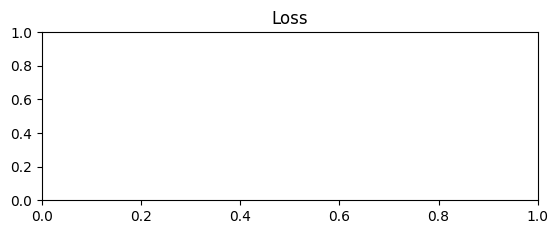

In [ ]:
# Plot loss during training (we can do this because we saved a "history" during training)
from matplotlib import pyplot
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
# pyplot.ylim(0,20)

# Mini Holdout

In [12]:
# Load and preprocess mini_holdout
mini_holdout = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/biking_holdout_test_mini.csv')
mini_holdout = preprocess_bike_data(mini_holdout)

In [14]:
# Ensure that mini_holdout has the same columns as the training data
missing_cols = set(bikes.columns) - set(mini_holdout.columns)
for col in missing_cols:
    mini_holdout[col] = 0

# Drop unnecessary columns in mini_holdout
mini_holdout = mini_holdout.drop(['dteday', 'datetime'], axis=1, errors='ignore')

# Align columns to match the training data
mini_holdout = mini_holdout[bikes.columns.drop(['dteday', 'casual', 'registered', 'combined_y', 'datetime'])]

# Apply the same scaler fitted on the training data
mini_holdout = minmax_scaler.transform(mini_holdout)

# Check the shape of mini_holdout
print(mini_holdout.shape)

# Make predictions
mini_holdout_predictions = model.predict(mini_holdout)

# Format and export data
predictions_table = pd.DataFrame(mini_holdout_predictions, columns=['predictions'])
predictions_table.to_csv('team5-module4-predictions.csv', index=False)
print(predictions_table.value_counts())

(384, 15)
12/12 [==============================] - 0s 4ms/step
predictions 
-68.672035      1
-62.124184      1
 559.772156     1
 558.735596     1
 556.075867     1
               ..
 110.418053     1
 110.025505     1
 108.147942     1
 99.335045      1
 1562.328979    1
Name: count, Length: 384, dtype: int64
